Importando as bibliotecas necessárias

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycircular as pycircular
from scipy.stats import chi2_contingency
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
LE = preprocessing.LabelEncoder()
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None)

Unindo os dataframes

In [2]:
df_channels = pd.read_csv(r'bases\channels.csv')
df_deliveries = pd.read_csv(r'bases\deliveries.csv')
df_drivers = pd.read_csv(r'bases\drivers.csv')
df_hubs = pd.read_csv(r'bases\hubs.csv')
df_orders = pd.read_csv(r'bases\orders.csv')
df_stores = pd.read_csv(r'bases\stores.csv')
df_payments = pd.read_csv(r'bases\payments.csv')

df = pd.merge(df_orders, df_stores, on='store_id')
df = pd.merge(df, df_hubs, on='hub_id')
df = pd.merge(df, df_channels, on='channel_id')
df = pd.merge(df, df_payments, on='payment_order_id')
df = pd.merge(df, df_deliveries, on='delivery_order_id')
df = pd.merge(df, df_drivers, on='driver_id')

df.shape

(287459, 48)

In [17]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
order_id,215946.0,82105757.224264,68410055.0,76148637.5,82885660.0,87904480.75,93139799.0,7048877.06835
order_amount,215946.0,88.791656,0.0,38.0,65.0,111.0,15000.0,118.405779
order_delivery_fee,215946.0,5.522793,0.0,0.0,6.0,11.0,990.0,5.710961
order_delivery_cost,215946.0,6.920633,0.0,5.0,7.0,8.0,109.0,2.379256
order_created_hour,215946.0,16.939508,0.0,15.0,17.0,22.0,23.0,6.047609
order_created_minute,215946.0,29.344734,0.0,14.0,29.0,44.0,59.0,17.222617
order_created_day,215946.0,16.075051,1.0,9.0,16.0,24.0,31.0,8.714806
order_created_month,215946.0,2.654539,1.0,2.0,3.0,4.0,4.0,1.099831
order_moment_created,215946,2021-03-07 08:04:38.129388800,2021-01-01 02:32:51,2021-02-07 00:16:31,2021-03-11 14:44:50,2021-04-03 20:49:41.500000,2021-04-30 23:59:26,NaN
order_moment_finished,215946,2021-03-07 09:01:13.881035264,2021-01-01 14:50:20,2021-02-07 01:08:34.249999872,2021-03-11 15:38:59,2021-04-03 21:40:13.750000128,2021-05-01 23:25:01,NaN


# Limpeza Inicial

In [3]:
grupo_pagamento = {
'DEBIT': 'CARD',
'CREDIT': 'CARD',
'DEBIT_STORE': 'CARD',
'CREDIT_STORE': 'CARD',
'INSTALLMENT_CREDIT_STORE': 'CARD',
'MEAL_BENEFIT': 'OTHER',
'STORE_DIRECT_PAYMENT': 'OTHER',
'PAYMENT_LINK': 'OTHER',
'MONEY': 'OTHER',
'BANK_TRANSFER_DC': 'OTHER',
'VOUCHER_DC': 'VOUCHER',
'VOUCHER_OL': 'VOUCHER',
'VOUCHER_STORE': 'VOUCHER'
}

def preparacao_inicial(df):

    #Retirar colunas não importantes
    df = df.drop(columns=['store_id','channel_id','payment_order_id','delivery_order_id','hub_id','payment_id','delivery_id', 'driver_id','order_moment_accepted', 'order_moment_ready',
        'order_moment_collected', 'order_moment_in_expedition',
        'order_moment_delivering', 'order_moment_delivered'])


    #Retirar pedidos cancelados, que estão sendo entregues e que não foram pagos
    df = df[~df['order_status'].isin(['CANCELED'])]
    df = df[~df['delivery_status'].isin(['DELIVERING'])]
    df = df[~df['payment_status'].isin(['CHARGEBACK', 'AWAITING'])]
    df['payment_method'] = df['payment_method'].replace(grupo_pagamento)
    
    df = df.drop(columns=['order_status','payment_status','delivery_status','payment_fee'])

    #Tratamento dos dados nulos
    df = df.dropna(subset=['delivery_distance_meters','store_latitude','store_longitude','order_moment_finished','order_metric_cycle_time','order_metric_transit_time'])

    df['order_delivery_cost'] = df['order_delivery_cost'].fillna(0.0)
    df['store_plan_price'] = df['store_plan_price'].fillna(0.0)

    df['order_moment_created'] = pd.to_datetime(df['order_moment_created'])
    df['order_moment_finished'] = pd.to_datetime(df['order_moment_finished'])

    #Valores inconsistentes
    df = df.drop_duplicates()
    df = df.loc[df['order_metric_transit_time'] >= 0]
    df = df.loc[df['order_metric_walking_time'] >= 0]
    df = df.loc[df['order_metric_paused_time'] >= 0]
    df = df.loc[df['order_metric_collected_time'] >= 0]
    
    #Outliers
    
    return df

In [4]:
df = preparacao_inicial(df)

# Função para calcular outliers
def calcula_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    diff = q3 - q1
    lim_inf = q1 - 1.5 * diff
    lim_sup = q3 + 1.5 * diff
    outliers = column[(column < lim_inf) | (column > lim_sup)] # Definição de outliers pelos percentis e limites
    return outliers, lim_inf, lim_sup

# Função para contar outliers e calcular a porcentagem
def conta_outliers(df):
    outlier_info = pd.DataFrame(columns=['Coluna', 'Outliers', 'Porcentagem', 'lim_inf', 'lim_sup']) # Criando um novo DataFrame
    for col in df.select_dtypes(include=['int', 'float']): # Loop para verificar cada coluna numérica
        outliers, lim_inf, lim_sup = calcula_outliers(df[col]) # Chamando a função para calcular outliers
        outlier_count = len(outliers) # Verificando o tamanho da lista
        percentage = (outlier_count / len(df)) * 100 # Porcentagem de outliers
        outlier_info.loc[len(outlier_info)] = [col, outlier_count, percentage, lim_inf, lim_sup] # Atribuindo valores usando .loc[]
    return outlier_info # Retornando DataFrame




outlier_df = conta_outliers(df)
print(outlier_df)

C:\Users\matus\AppData\Local\Temp\ipykernel_18376\3119386263.py:39: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\matus\AppData\Local\Temp\ipykernel_18376\3119386263.py:40: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



                               Coluna  Outliers  Porcentagem       lim_inf  \
0                            order_id         0     0.000000  5.882133e+07   
1                        order_amount     11639     5.033516 -7.450000e+01   
2                  order_delivery_fee        64     0.027678 -1.650000e+01   
3                 order_delivery_cost      9064     3.919907  5.000000e-01   
4                  order_created_hour     20223     8.745837  4.500000e+00   
5                order_created_minute         0     0.000000 -3.100000e+01   
6                   order_created_day         0     0.000000 -1.350000e+01   
7                 order_created_month         0     0.000000 -1.000000e+00   
8         order_metric_collected_time     14631     6.327466 -3.000000e+00   
9            order_metric_paused_time     20141     8.710375 -5.000000e+00   
10       order_metric_production_time      9071     3.922934 -9.000000e+00   
11          order_metric_walking_time     10851     4.692730 -2.

In [5]:
df.shape

(231230, 30)

In [21]:
df.head()

,order_id,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_day,order_created_month,order_moment_created,order_moment_finished,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time,store_segment,store_plan_price,store_latitude,store_longitude,hub_city,hub_latitude,hub_longitude,channel_type,payment_amount,payment_method,delivery_distance_meters,driver_modal,driver_type
0,89066010,64,6,5.0,15,49,9,4,2021-04-09 15:49:59,2021-04-09 16:27:23,4.0,4.0,20.0,8.0,12.0,3.0,37.0,FOOD,49.0,-23.595776,-46.685986,S�O PAULO,-23.595001,-46.685986,MARKETPLACE,71.22,ONLINE,172.0,BIKER,FREELANCE
1,74452603,74,11,6.0,21,19,29,1,2021-01-29 21:19:06,2021-01-29 21:56:32,0.0,0.0,15.0,3.0,4.0,17.0,37.0,FOOD,0.0,-23.561052,-46.558975,S�O PAULO,-23.561052,-46.558975,MARKETPLACE,86.80,ONLINE,2265.0,MOTOBOY,FREELANCE
2,78635930,82,9,8.0,20,49,18,2,2021-02-18 20:49:48,2021-02-18 21:48:07,1.0,6.0,4.0,4.0,11.0,42.0,58.0,FOOD,0.0,-22.996847,-43.361200,RIO DE JANEIRO,-22.996847,-43.359634,MARKETPLACE,92.80,ONLINE,2175.0,MOTOBOY,FREELANCE
3,70338727,85,9,8.0,22,35,9,1,2021-01-09 22:35:40,2021-01-09 23:13:46,2.0,1.0,8.0,6.0,7.0,22.0,38.0,FOOD,49.0,-22.996847,-43.361200,RIO DE JANEIRO,-22.996847,-43.359634,MARKETPLACE,94.90,ONLINE,2175.0,MOTOBOY,LOGISTIC OPERATOR
4,68874888,107,11,6.0,16,22,3,1,2021-01-03 16:22:42,2021-01-03 17:07:33,5.0,3.0,20.0,5.0,8.0,15.0,44.0,FOOD,0.0,-23.017473,-43.479940,RIO DE JANEIRO,-23.017473,-43.479940,MARKETPLACE,119.25,ONLINE,273.0,BIKER,FREELANCE


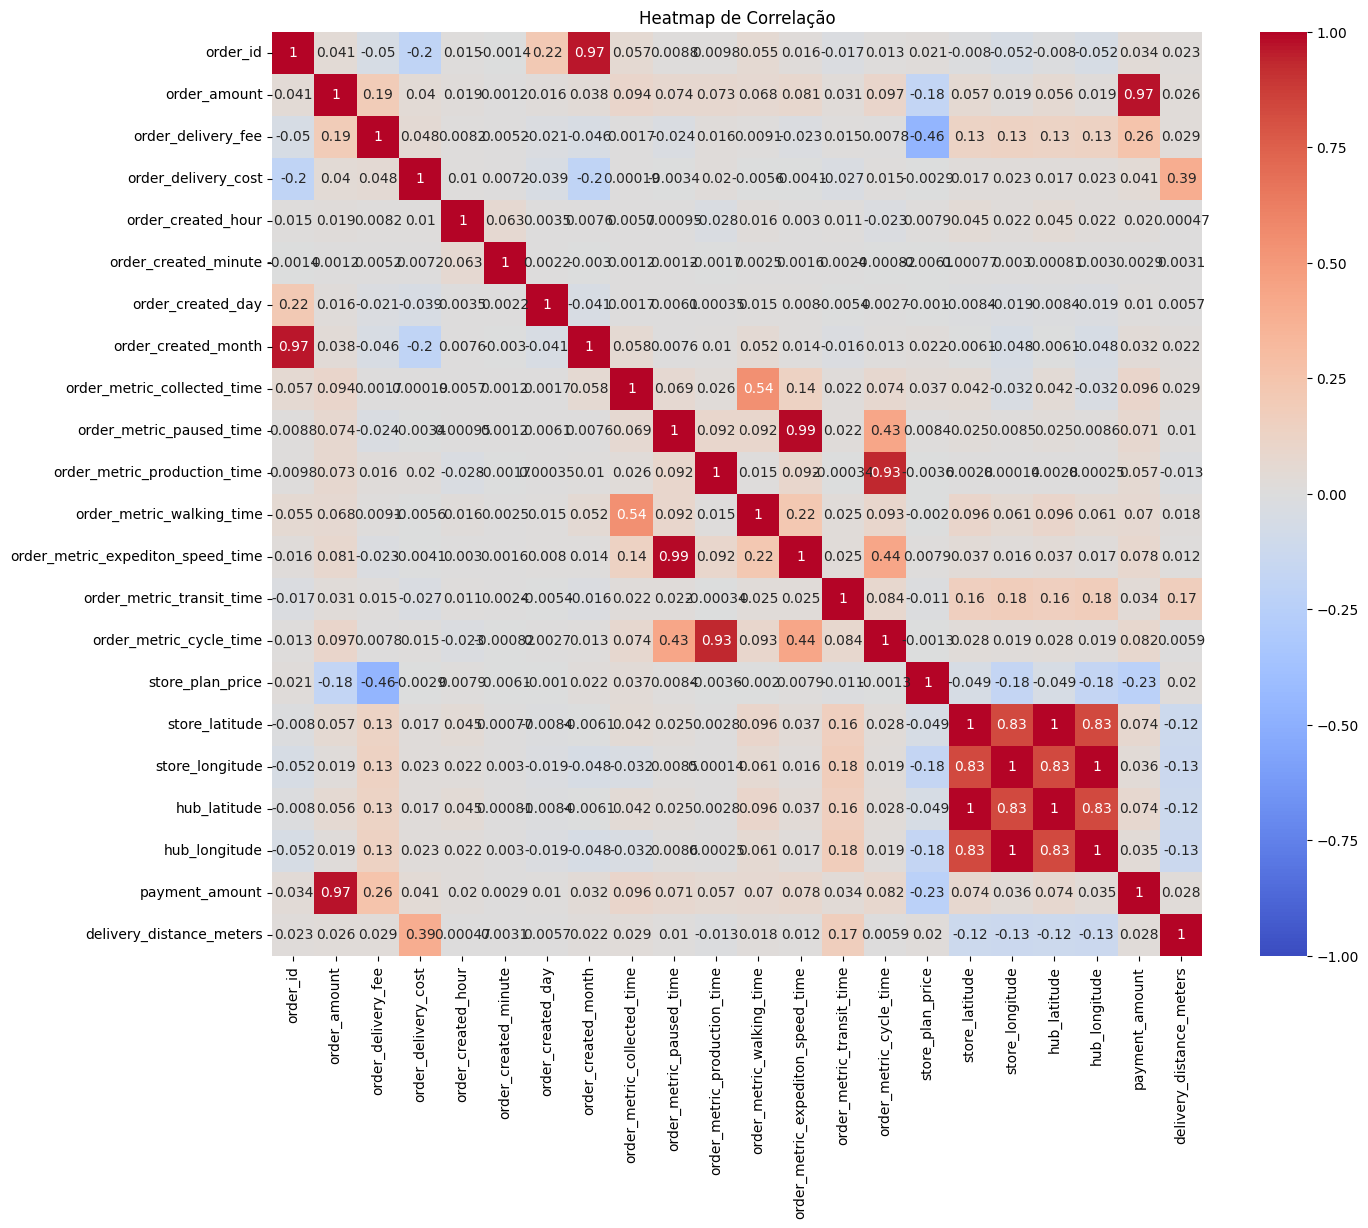

In [30]:
plt.figure(figsize=(15, 12)) 
sns.heatmap(df.select_dtypes(include=["int","float"]).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação')
plt.show()

# Order_metrics

Para os order_metrics de menores expressão (média dos valores menores que 8 minutos), seu valor de soma no tempo total será a ESCOLHER.

No final ver se vale mais a pena (mse_score) usar a média ou mediana

In [310]:
#Médias
avg_walking = df['order_metric_walking_time'].mean()
avg_collected = df['order_metric_collected_time'].mean()
avg_paused = df['order_metric_paused_time'].mean()

In [46]:
#Medianas
median_walking = df['order_metric_walking_time'].median()
median_collected = df['order_metric_collected_time'].median()
median_paused = df['order_metric_paused_time'].median()

median = median_paused + median_walking + median_collected

# Order_metric_production_time

# Order_metric_expediton_speed_time

In [76]:
colunas_exped = ['store_latitude','store_longitude','order_delivery_fee', 'driver_type', 'order_created_month','store_plan_price','order_metric_expediton_speed_time']

#Colunas
#latitude_store: 17.86 KNN
#latitude,longitude_store: 17.854 KNN
#latitude,longitude_store, hub_latitude: 17.858 KNN
#latitude,longitude_store, hub_latitude,longitude: 17.858 KNN
#latitude,longitude_store, plan_price: 17.08 KNN
#latitude,longitude_store, plan_price,order_amount: 17.907 KNN
#latitude,longitude_store, plan_price, delivery_fee: 16.86 KNN
#latitude,longitude_store, plan_price, delivery_fee e cost: 17.9 KNN
#latitude,longitude_store, plan_price, delivery_fee, hour: 17.115 KNN
#latitude,longitude_store, plan_price, delivery_fee, day: 17.8 KNN
#latitude,longitude_store, plan_price, delivery_fee, month: 16.84 KNN
#latitude,longitude_store, plan_price, delivery_fee, month, payment_amount: 17.96 KNN
#latitude,longitude_store, plan_price, delivery_fee, month, : 18 RL
#latitude,longitude_store, plan_price, delivery_fee, month, modal: 16.869 KNN
#latitude,longitude_store, plan_price, delivery_fee, month, type: 16.84 KNN


df_exped = df[colunas_exped]
df_exped = df_exped.dropna(subset=['order_metric_expediton_speed_time'])

df_exped = df_exped.loc[df_exped['order_metric_expediton_speed_time'] <= 25]

def type(x):
    if x == 'FREELANCER':
        return 0
    else:
        return 1
    
# df_exped['driver_type'] = df_exped['driver_type'].apply(lambda x: type(x))

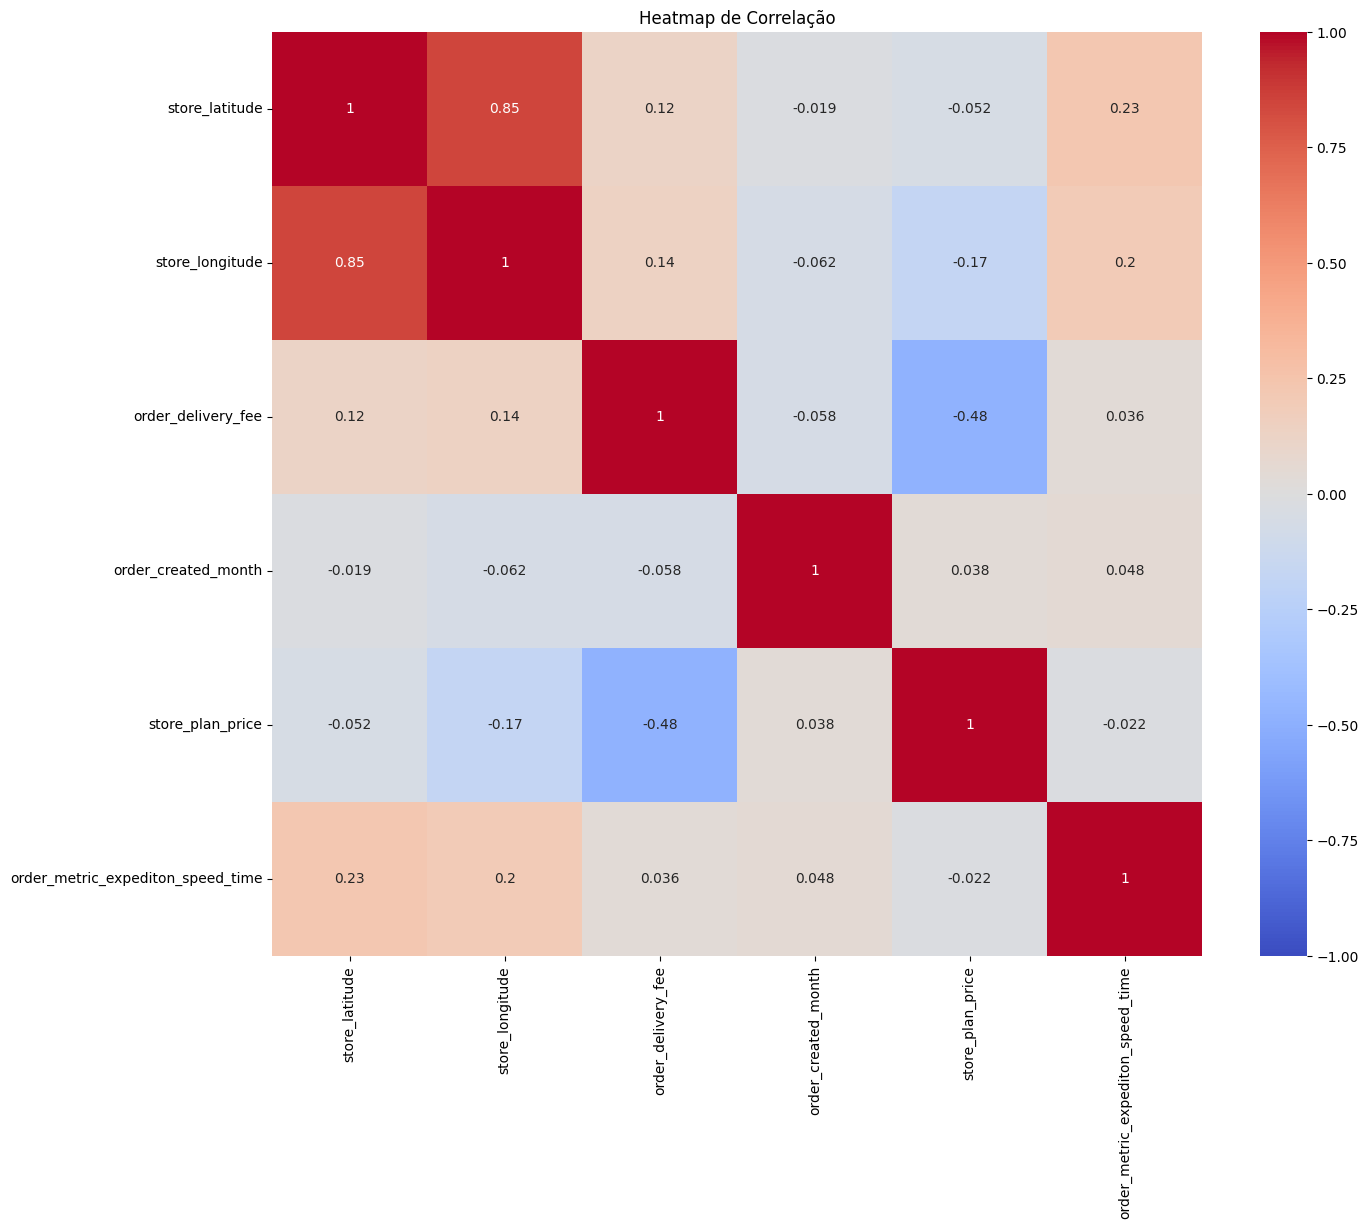

In [77]:
plt.figure(figsize=(15, 12)) 
sns.heatmap(df_exped.select_dtypes(include=["int","float"]).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação')
plt.show()

In [78]:
nomes_colunas_numericas = df_exped.select_dtypes(exclude=['object','datetime']).columns

for coluna in nomes_colunas_numericas:
    data1 = df_exped[coluna]
    data2 = df_exped['order_metric_expediton_speed_time']

    t_statistic, p_value = ttest_ind(data1, data2)

    print("\n")
    print(coluna)
    print("Estatística t:", t_statistic)
    print("Valor p:", p_value)



store_latitude
Estatística t: -2994.2679029758106
Valor p: 0.0


store_longitude
Estatística t: -4872.093621555128
Valor p: 0.0


order_delivery_fee
Estatística t: -96.62890839747254
Valor p: 0.0


order_created_month
Estatística t: -448.7918172243563
Valor p: 0.0


store_plan_price
Estatística t: 311.5179366081895
Valor p: 0.0


order_metric_expediton_speed_time
Estatística t: 0.0
Valor p: 1.0


In [73]:
print(df_exped.columns)

def cat_var(tab, x):
    if x == 0:
        cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
    if x == 1:
        cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
    return cat

def preparacao(tab):
    dados = tab.copy()
    order_metric_expediton_speed_time = dados.pop("order_metric_expediton_speed_time")
    return dados, order_metric_expediton_speed_time

tam_div = round(0.8 * len(df_exped)) # Tamanho da separação
tab_treino = df_exped.iloc[:tam_div] # Definindo parte a ser utilizada para treino
tab_valid = df_exped.iloc[tam_div:] # Definindo parte a ser utilizada para verificação

# Dados
X_treino = preparacao(tab_treino)[0]
X_valid = preparacao(tab_valid)[0]

Y_treino = preparacao(tab_treino)[1]
Y_valid = preparacao(tab_valid)[1]

numk = 800
modelo_exped = KNeighborsRegressor(n_neighbors=numk)

modelo_exped.fit(X_treino, Y_treino) # Treinando o regressor
Y_prev_valid = modelo_exped.predict(X_valid) # Prevendo os valores

# Calcular o MSE
mse = mean_squared_error(Y_valid, Y_prev_valid)
print('MSE:', mse) # Exibindo o MSE

r2 = r2_score(Y_valid, Y_prev_valid)
print('R²:', r2) # Exibindo o R²


Index(['store_latitude', 'store_longitude', 'order_delivery_fee',
       'driver_type', 'order_created_month', 'store_plan_price',
       'order_metric_expediton_speed_time'],
      dtype='object')
MSE: 16.84645406591882
R²: 0.14299131861543324


# Order_metric_transit_time

Para prever o tempo de trânsito, não usaremos todas as categorias.

In [169]:
colunas_transito = ['delivery_distance_meters','order_amount','order_created_hour','order_created_minute','order_created_month', 'order_created_day','order_delivery_fee','store_longitude','order_delivery_cost','store_latitude','order_metric_transit_time']

#Colunas e modelos com melhor MSE
#delivery_distance_meters: 77.205 KNN
#distance, modal : 77.215 KNN
#distance, order_amount: 77.179 KNN
#distance, order_amount, hour: 77.174 KNN
#distance, order_amount, hour, latitude: 75.197 LR
#distance, order_amount, hour, latitude, delivery_cost: 74.222 LR
#distance, order_amount, hour, latitude, delivery_cost, delivery_fee: 74.191 LR
#distance, order_amount, hour, latitude, delivery_cost, delivery_fee, longitude: 73.58 LR
#distance, order_amount, hour, latitude, delivery_cost, delivery_fee, longitude, type: 73.58 LR
#distance, order_amount, hour, latitude, delivery_cost, delivery_fee, longitude, dia: 73.569 LR
#distance, order_amount, hour, latitude, delivery_cost, delivery_fee, longitude, dia, mes: 73.447 LR
#distance, order_amount, hour, latitude, delivery_cost, delivery_fee, longitude, dia, mes, minuto: 73.447 LR
#distance, order_amount, hour, latitude, delivery_cost, delivery_fee, longitude, dia, mes, hour_angle: 73.309 LR
#distance, order_amount, hour,latitude, delivery_cost, delivery_fee, longitude, dia, mes, minuto, hour_angle: 73.303 LR

#Limpeza
df_transito = df[colunas_transito]
df_transito = df_transito.dropna(subset=['order_metric_transit_time'])

df_transito = df_transito.loc[df_transito['order_metric_transit_time'] <= 50]
df_transito = df_transito.loc[df_transito['delivery_distance_meters'] <= 3500]

#Variável de ângulo da hora

# Calculando a representação circular para as horas
df_transito['hour_angle'] = (df_transito['order_created_hour'] % 12) * 30 + (df_transito['order_created_minute'] / 60) * 30
# Normalizando os ângulos para o intervalo [0, 360)
df_transito['hour_angle'] = df_transito['hour_angle'] % 360

colunas = df_transito.columns.tolist()

# Mover 'coluna_alvo' para o início da lista
colunas.insert(0, colunas.pop(colunas.index('hour_angle')))

# Reorganizar as colunas no DataFrame
df_transito = df_transito[colunas]


In [72]:
print(df_transito.columns)

def cat_var(tab, x):
    if x == 0:
        cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
    if x == 1:
        cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
    return cat

def preparacao(tab):
    dados = tab.copy()
    order_metric_transit_time = dados.pop("order_metric_transit_time")
    return dados, order_metric_transit_time

tam_div = round(0.8 * len(df_transito)) # Tamanho da separação
tab_treino = df_transito.iloc[:tam_div] # Definindo parte a ser utilizada para treino
tab_valid = df_transito.iloc[tam_div:] # Definindo parte a ser utilizada para verificação

# Dados
X_treino = preparacao(tab_treino)[0]
X_valid = preparacao(tab_valid)[0]

Y_treino = preparacao(tab_treino)[1]
Y_valid = preparacao(tab_valid)[1]

#LinearRegression
modelo = LinearRegression()

modelo.fit(X_treino, Y_treino) # Treinando o regressor
Y_prev_valid = modelo.predict(X_valid) # Prevendo os valores

# Calcular o MSE
mse = mean_squared_error(Y_valid, Y_prev_valid)
print('MSE:', mse) # Exibindo o MSE

r2 = r2_score(Y_valid, Y_prev_valid)
print('R²:', r2) # Exibindo o R²

NameError: name 'df_transito' is not defined

### Análise das colunas

- Variáveis numéricas: T-test

OBS: Generally, any t-value greater than +3.17 or less than - 3.17 is acceptable.

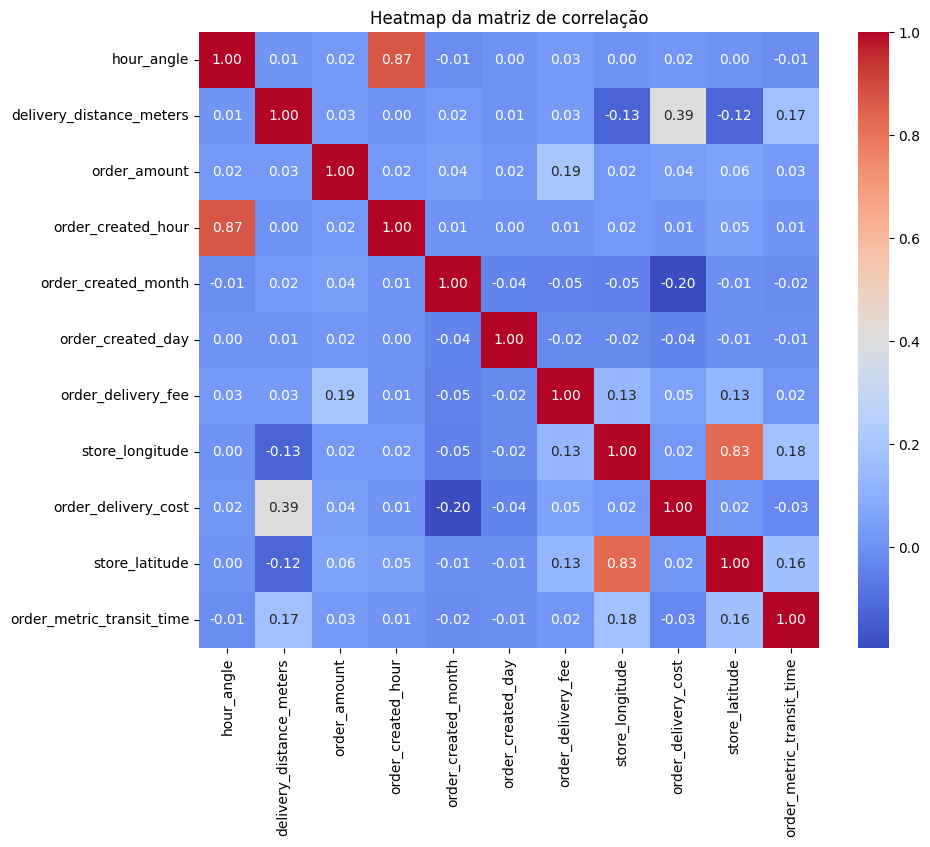

In [177]:
plt.figure(figsize=(10, 8))  # Tamanho da figura


# Substitua df pelo seu DataFrame
sns.heatmap(df_transito.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adicione um título
plt.title('Heatmap da matriz de correlação')

# Exiba o plot
plt.show()

In [178]:
nomes_colunas_numericas = df_transito.select_dtypes(exclude=['object','datetime']).columns

for coluna in nomes_colunas_numericas:
    data1 = df_transito[coluna]
    data2 = df_transito['order_metric_transit_time']

    t_statistic, p_value = ttest_ind(data1, data2)

    print("\n")
    print(coluna)
    print("Estatística t:", t_statistic)
    print("Valor p:", p_value)



hour_angle
Estatística t: 688.8038729335409
Valor p: 0.0


delivery_distance_meters
Estatística t: 789.3487707308802
Valor p: 0.0


order_amount
Estatística t: 278.85180098523773
Valor p: 0.0


order_created_hour
Estatística t: 17.67290287995023
Valor p: 7.265732446721026e-70


order_created_month
Estatística t: -653.8473450549106
Valor p: 0.0


order_created_day
Estatística t: -14.62227822852405
Valor p: 2.091811608158669e-48


order_delivery_fee
Estatística t: -443.04710843536486
Valor p: 0.0


store_longitude
Estatística t: -2856.119194941881
Valor p: 0.0


order_delivery_cost
Estatística t: -464.412817712288
Valor p: 0.0


store_latitude
Estatística t: -1881.356044924922
Valor p: 0.0


order_metric_transit_time
Estatística t: 0.0
Valor p: 1.0


In [179]:
df_transito.head()

,hour_angle,delivery_distance_meters,order_amount,order_created_hour,order_created_month,order_created_day,order_delivery_fee,store_longitude,order_delivery_cost,store_latitude,order_metric_transit_time
0,114.5,172.0,64,15,4,9,6,-46.685986,5.0,-23.595776,3.0
1,279.5,2265.0,74,21,1,29,11,-46.558975,6.0,-23.561052,17.0
2,264.5,2175.0,82,20,2,18,9,-43.361200,8.0,-22.996847,42.0
3,317.5,2175.0,85,22,1,9,9,-43.361200,8.0,-22.996847,22.0
4,131.0,273.0,107,16,1,3,11,-43.479940,6.0,-23.017473,15.0


Data Prep

In [176]:
print(df_transito.columns)

def cat_var(tab, x):
    if x == 0:
        cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
    if x == 1:
        cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
    return cat

def preparacao(tab):
    dados = tab.copy()
    order_metric_transit_time = dados.pop("order_metric_transit_time")
    return dados, order_metric_transit_time

tam_div = round(0.8 * len(df_transito)) # Tamanho da separação
tab_treino = df_transito.iloc[:tam_div] # Definindo parte a ser utilizada para treino
tab_valid = df_transito.iloc[tam_div:] # Definindo parte a ser utilizada para verificação

# Dados
X_treino = preparacao(tab_treino)[0]
X_valid = preparacao(tab_valid)[0]

Y_treino = preparacao(tab_treino)[1]
Y_valid = preparacao(tab_valid)[1]

#LinearRegression
modelo_transito = LinearRegression()

modelo_transito.fit(X_treino, Y_treino) # Treinando o regressor
Y_prev_valid = modelo_transito.predict(X_valid) # Prevendo os valores

# Calcular o MSE
mse = mean_squared_error(Y_valid, Y_prev_valid)
print('MSE:', mse) # Exibindo o MSE

r2 = r2_score(Y_valid, Y_prev_valid)
print('R²:', r2) # Exibindo o R²


Index(['hour_angle', 'delivery_distance_meters', 'order_amount',
       'order_created_hour', 'order_created_month', 'order_created_day',
       'order_delivery_fee', 'store_longitude', 'order_delivery_cost',
       'store_latitude', 'order_metric_transit_time'],
      dtype='object')
MSE: 73.30998373525453
R²: 0.0850266375058023


# Modelo Final

Agora que todos os order_metric já tem seus modelos agora é necessária a junção de todos.

Funções preparações:

Como cada modelo utilizou de colunas diferente e meios diferentes, para prever em um novo dataframe essas funções serão criadas para facilitar o processo de dataprep

In [ ]:
#Expedition_time

def prep_exped(df, modelo):
    colunas_exped = ['store_latitude','store_longitude','order_delivery_fee', 'driver_type', 'order_created_month','store_plan_price','order_metric_expediton_speed_time']

    df_exped = df[colunas_exped]
    df_exped = df_exped.dropna(subset=['order_metric_expediton_speed_time'])

    df_exped = df_exped.loc[df_exped['order_metric_expediton_speed_time'] <= 25]

    df_exped['driver_type'] = df_exped['driver_type'].apply(lambda x: type(x))

    # Dados
    X_test = preparacao(df_exped)[0]

    Y_prev = modelo.predict(X_test)
    
    return Y_prev

In [ ]:
#Transit_time

def prep_transito(df, modelo):
    colunas_transito = ['delivery_distance_meters','order_amount','order_created_hour','order_created_minute','order_created_month', 'order_created_day','order_delivery_fee','store_longitude','order_delivery_cost','store_latitude','order_metric_transit_time']

    df_transito = df[colunas_transito]
    df_transito = df_transito.dropna(subset=['order_metric_transit_time'])

    df_transito = df_transito.loc[df_transito['order_metric_transit_time'] <= 50]
    df_transito = df_transito.loc[df_transito['delivery_distance_meters'] <= 3500]

    #Variável de ângulo da hora

    # Calculando a representação circular para as horas
    df_transito['hour_angle'] = (df_transito['order_created_hour'] % 12) * 30 + (df_transito['order_created_minute'] / 60) * 30
    # Normalizando os ângulos para o intervalo [0, 360)
    df_transito['hour_angle'] = df_transito['hour_angle'] % 360

    colunas = df_transito.columns.tolist()

    # Mover 'coluna_alvo' para o início da lista
    colunas.insert(0, colunas.pop(colunas.index('hour_angle')))

    # Reorganizar as colunas no DataFrame
    df_transito = df_transito[colunas]

    X_test = preparacao(df_transito)[0]

    Y_prev = modelo.predict(X_test)
    

    return Y_prev

In [ ]:
y_pred_production = prep_transito(df,modelo_production)
y_pred_exped = prep_transito(df,modelo_exped)
y_pred_transito = prep_transito(df,modelo_transito)

order_metric_cycle_time = []

for k in len(y_pred_transito):
    order_metric_cycle_time.append(y_pred_transito[k] + y_pred_exped[k] + y_pred_production[k] + median)